In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

In [2]:
# Importing the necessary packages
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from tqdm import tqdm
from PIL import Image
import io

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display, clear_output
import ipywidgets as widgets

In [4]:
# Data Preparation 

labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
X_train = []
Y_train  = []
X_test = []
Y_test = []
image_size=150

In [5]:
for label in labels:
    trainPath = os.path.join('../input/brain-tumor-classification-mri/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(label)
    
    testPath = os.path.join('../input/brain-tumor-classification-mri/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file))
        image = cv2.resize(image, (image_size, image_size))
        X_test.append(image)
        Y_test.append(label)
    
X_train = np.array(X_train)
X_test = np.array(X_test)

100%|██████████| 74/74 [00:00<00:00, 92.47it/s]


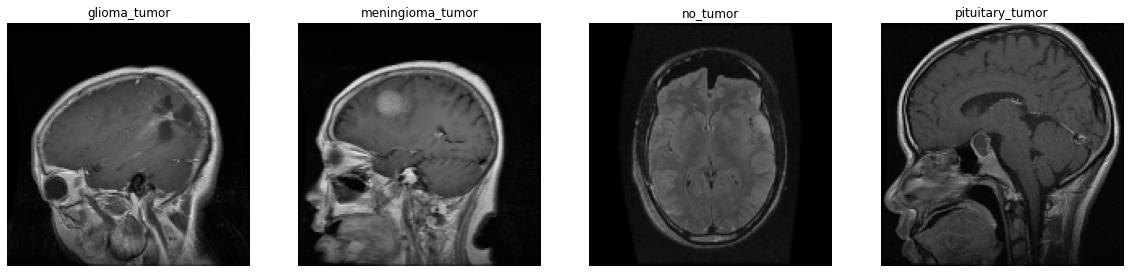

In [6]:
# Display of sample images of each label 

fig, ax = plt.subplots(1,4, figsize=(20,20))
k = 0
for i in range(0,4):
    if i==0: idx=0
    elif i==1: idx=827
    elif i==2: idx=1649
    else: idx=2045
    ax[k].imshow(X_train[idx])
    ax[k].set_title(Y_train[idx])
    ax[k].axis('off')
    k+=1

In [7]:
# Shuffle the train dataset 

X_train, Y_train = shuffle(X_train, Y_train, random_state=28)

In [8]:
X_train.shape

(2870, 150, 150, 3)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

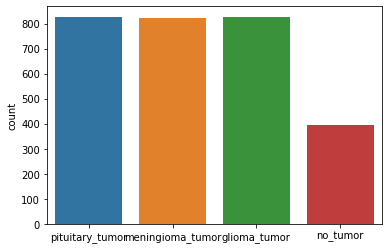

In [9]:
sns.countplot(Y_train)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

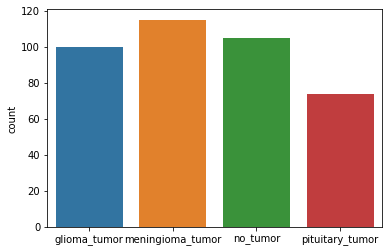

In [10]:
sns.countplot(Y_test)

In [11]:
# One hot encoding 

y_train_ = []
for i in Y_train:
    y_train_.append(labels.index(i))
Y_train = y_train_

Y_train = tf.keras.utils.to_categorical(Y_train)

y_test_ = []
for i in Y_test:
    y_test_.append(labels.index(i))
Y_test = y_test_

Y_test = tf.keras.utils.to_categorical(Y_test)

In [12]:
# Split the training and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=28)

In [13]:
# Transfer learning 
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

2022-07-11 15:47:44.405997: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 15:47:44.526127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 15:47:44.526908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 15:47:44.528033: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

31801344/31790344 [==============================] - 0s 0us/step


In [14]:
model = base_model.output
model = GlobalAveragePooling2D()(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs = base_model.input, outputs=model)

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_denta=0.0001, mode='auto', verbose=1)
tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("brain_tumor_classification.h5", monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)

2022-07-11 15:47:49.691886: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-07-11 15:47:49.691922: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-07-11 15:47:49.694672: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-07-11 15:47:49.890865: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-07-11 15:47:49.891033: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [17]:
# Data augmentation 

datagen = ImageDataGenerator(
featurewise_center=False,
samplewise_center=False,
featurewise_std_normalization=False,
samplewise_std_normalization=False,
zca_whitening=False,
rotation_range=10,
zoom_range=0.2,
width_shift_range=0.2,
horizontal_flip=False,
vertical_flip=False)

datagen.fit(X_train)

In [18]:
# Train the model
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),
                              validation_data=(X_val, Y_val), 
                              epochs=50, 
                              verbose=1,
                            callbacks=[tensorboard, checkpoint, reduce_lr])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-07-11 15:47:51.190472: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-07-11 15:48:03.381976: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/72 [..............................] - ETA: 22:16 - loss: 1.4567 - accuracy: 0.1562

2022-07-11 15:48:10.399173: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-07-11 15:48:10.399226: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/72 [..............................] - ETA: 1:03 - loss: 1.3608 - accuracy: 0.2969 

2022-07-11 15:48:10.966512: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-07-11 15:48:10.971739: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-07-11 15:48:11.143646: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 3005 callback api events and 3002 activity events. 
2022-07-11 15:48:11.234186: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-07-11 15:48:11.323770: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_07_11_15_48_11

2022-07-11 15:48:11.375172: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_07_11_15_48_11/504cf4409520.trace.json.gz
2022-07-11 15:48:11.499961: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/pl

72/72 [==============================] - 39s 285ms/step - loss: 0.5355 - accuracy: 0.8066 - val_loss: 1.1095 - val_accuracy: 0.8275

Epoch 00001: val_accuracy improved from -inf to 0.82753, saving model to brain_tumor_classification.h5
Epoch 2/50
72/72 [==============================] - 17s 235ms/step - loss: 0.2510 - accuracy: 0.9159 - val_loss: 0.5894 - val_accuracy: 0.8763

Epoch 00002: val_accuracy improved from 0.82753 to 0.87631, saving model to brain_tumor_classification.h5
Epoch 3/50
72/72 [==============================] - 18s 244ms/step - loss: 0.1771 - accuracy: 0.9386 - val_loss: 0.9049 - val_accuracy: 0.8345

Epoch 00003: val_accuracy did not improve from 0.87631
Epoch 4/50
72/72 [==============================] - 16s 228ms/step - loss: 0.1520 - accuracy: 0.9460 - val_loss: 0.7643 - val_accuracy: 0.8380

Epoch 00004: val_accuracy did not improve from 0.87631

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/50
72/72 [=================

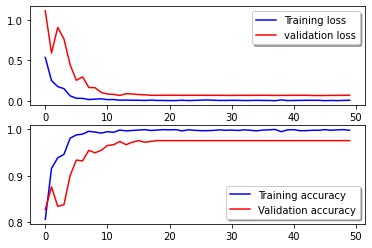

In [19]:
# Visualise the performance of the trained model & Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [20]:
# Evaluate the model 

pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(Y_test,axis=1)

In [21]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 79.95%


In [22]:
# Prediction on test data
img = cv2.imread('../input/brain-tumor-classification-mri/Testing/meningioma_tumor/image(10).jpg') 
opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
img = cv2.resize(opencvImage,(150,150))
img = img.reshape(1,150,150,3)
p = model.predict(img)
p = np.argmax(p,axis=1)[0]

if p==0:
        p='Glioma Tumor'
elif p==1:
        p='Meningioma Tumor'
elif p==2:
        print('The model predicts that there is no tumor')
else:
        p='Pituitary Tumor'

if p!=2:
        print(f'The Model predicts that it is a {p}')

The Model predicts that it is a Meningioma Tumor


In [23]:
# Prediction on test data
img = cv2.imread('../input/brain-tumor-classification-mri/Testing/no_tumor/image(103).jpg') 
opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
img = cv2.resize(opencvImage,(150,150))
img = img.reshape(1,150,150,3)
p = model.predict(img)
p = np.argmax(p,axis=1)[0]

if p==0:
        p='Glioma Tumor'
elif p==1:
        p='Meningioma Tumor'
elif p==2:
        print('The model predicts that there is no tumor')
else:
        p='Pituitary Tumor'

if p!=2:
        print(f'The Model predicts that it is a {p}')

The model predicts that there is no tumor


In [24]:
TEST_DIR='../input/brain-tumor-classification-mri/Testing'
#fetch images from the original validation dataset and resize them in order to plot the images.
images=[] 
n_classes=4
z_max=20
for i,filenames in enumerate(os.listdir(TEST_DIR)): 
    dir_fold=os.path.join(TEST_DIR, filenames)
    print(dir_fold)
    class_images=[]
    z=0
    for filename in os.listdir(dir_fold):
        if z < z_max:
            img_path = os.path.join(dir_fold, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img,(image_size,image_size))
            class_images.append(img)
            z+=1
        else:
            break
    images.append(class_images)
images=images[:20]

../input/brain-tumor-classification-mri/Testing/no_tumor
../input/brain-tumor-classification-mri/Testing/pituitary_tumor
../input/brain-tumor-classification-mri/Testing/meningioma_tumor
../input/brain-tumor-classification-mri/Testing/glioma_tumor


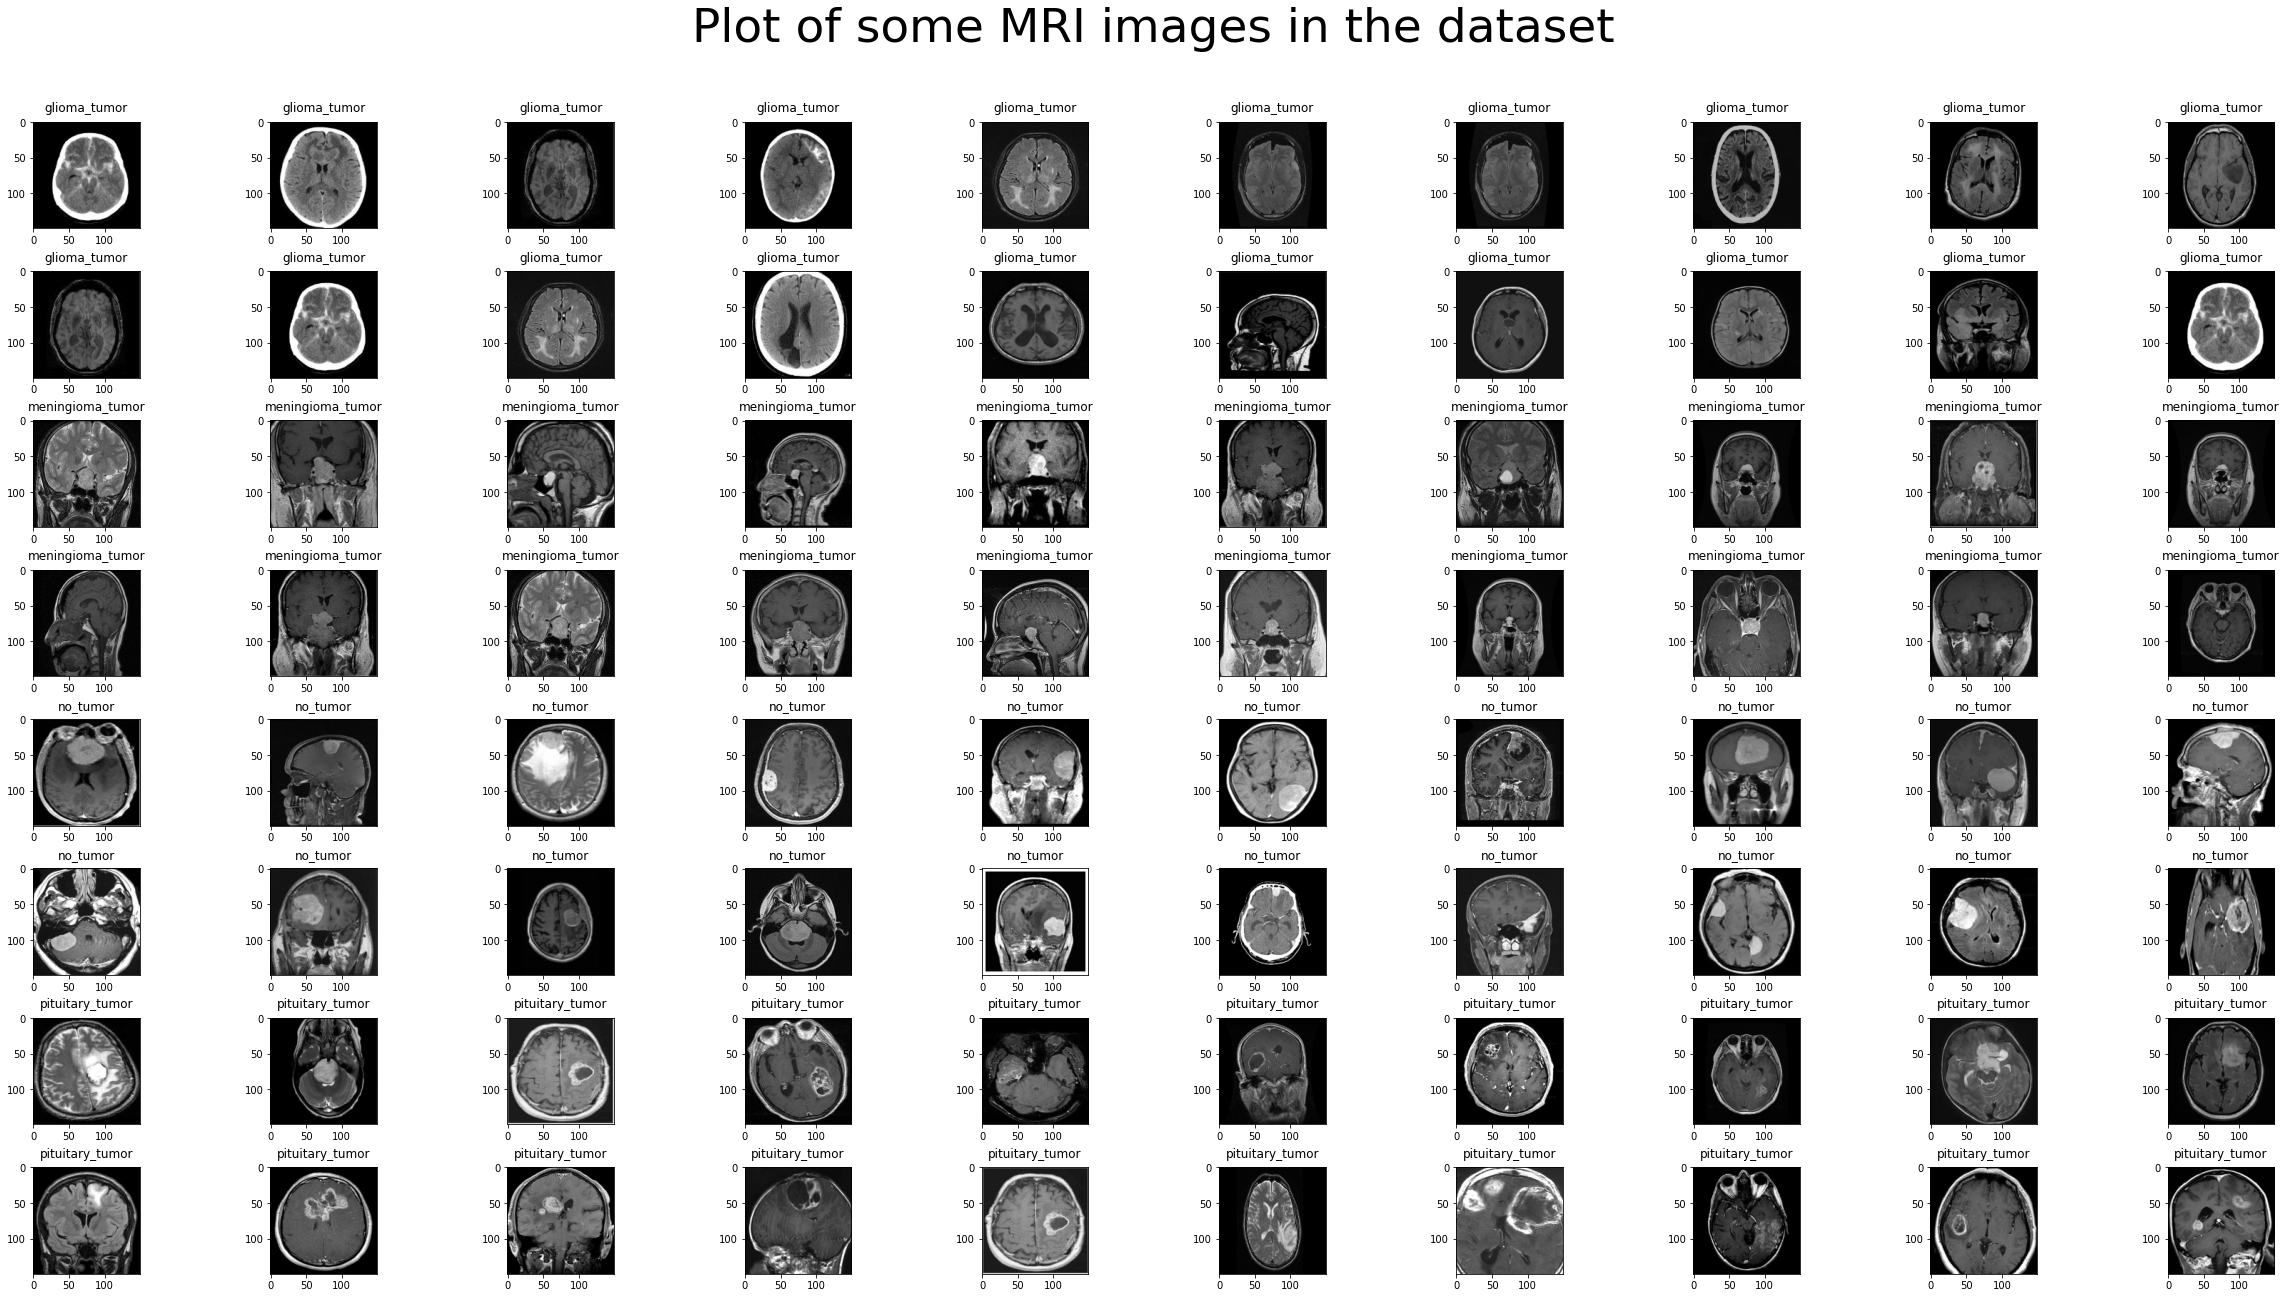

In [25]:
# Plotting the images based on columns and z_max 
columns = 10
fig,axes=plt.subplots(int(len(images)*len(images[0])/columns),columns,figsize=(40,20))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i,ind in enumerate(images):
    #print(images_class)
    fig.suptitle('Plot of some MRI images in the dataset',fontsize=47)
    for j, image in enumerate(ind):
        #print(j,image)
        axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].imshow(image)
        axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].set_title(f'{labels[i]}',pad=10)
#image_plotting(X_test[:1])
#plt.savefig(os.path.join('plots/','Some_MRI_images_in_the_dataset_white.png'), dpi=300,facecolor='w')

In [26]:
X_test_images=dict(zip(labels,[[],[],[],[]]))
for y,ele in enumerate(pred):
    for i,x in enumerate(X_test_images):
        #num=pred[ind]
        if ele==i:
            if len(X_test_images[labels[i]])<z_max:
                X_test_images[labels[i]].append(X_test[y])
X_test_images=[X_test_images[i]  for i in X_test_images]

The Model predicts that it is a Meningioma Tumor
The model predicts that there is no tumor
The model predicts that there is no tumor
The model predicts that there is no tumor


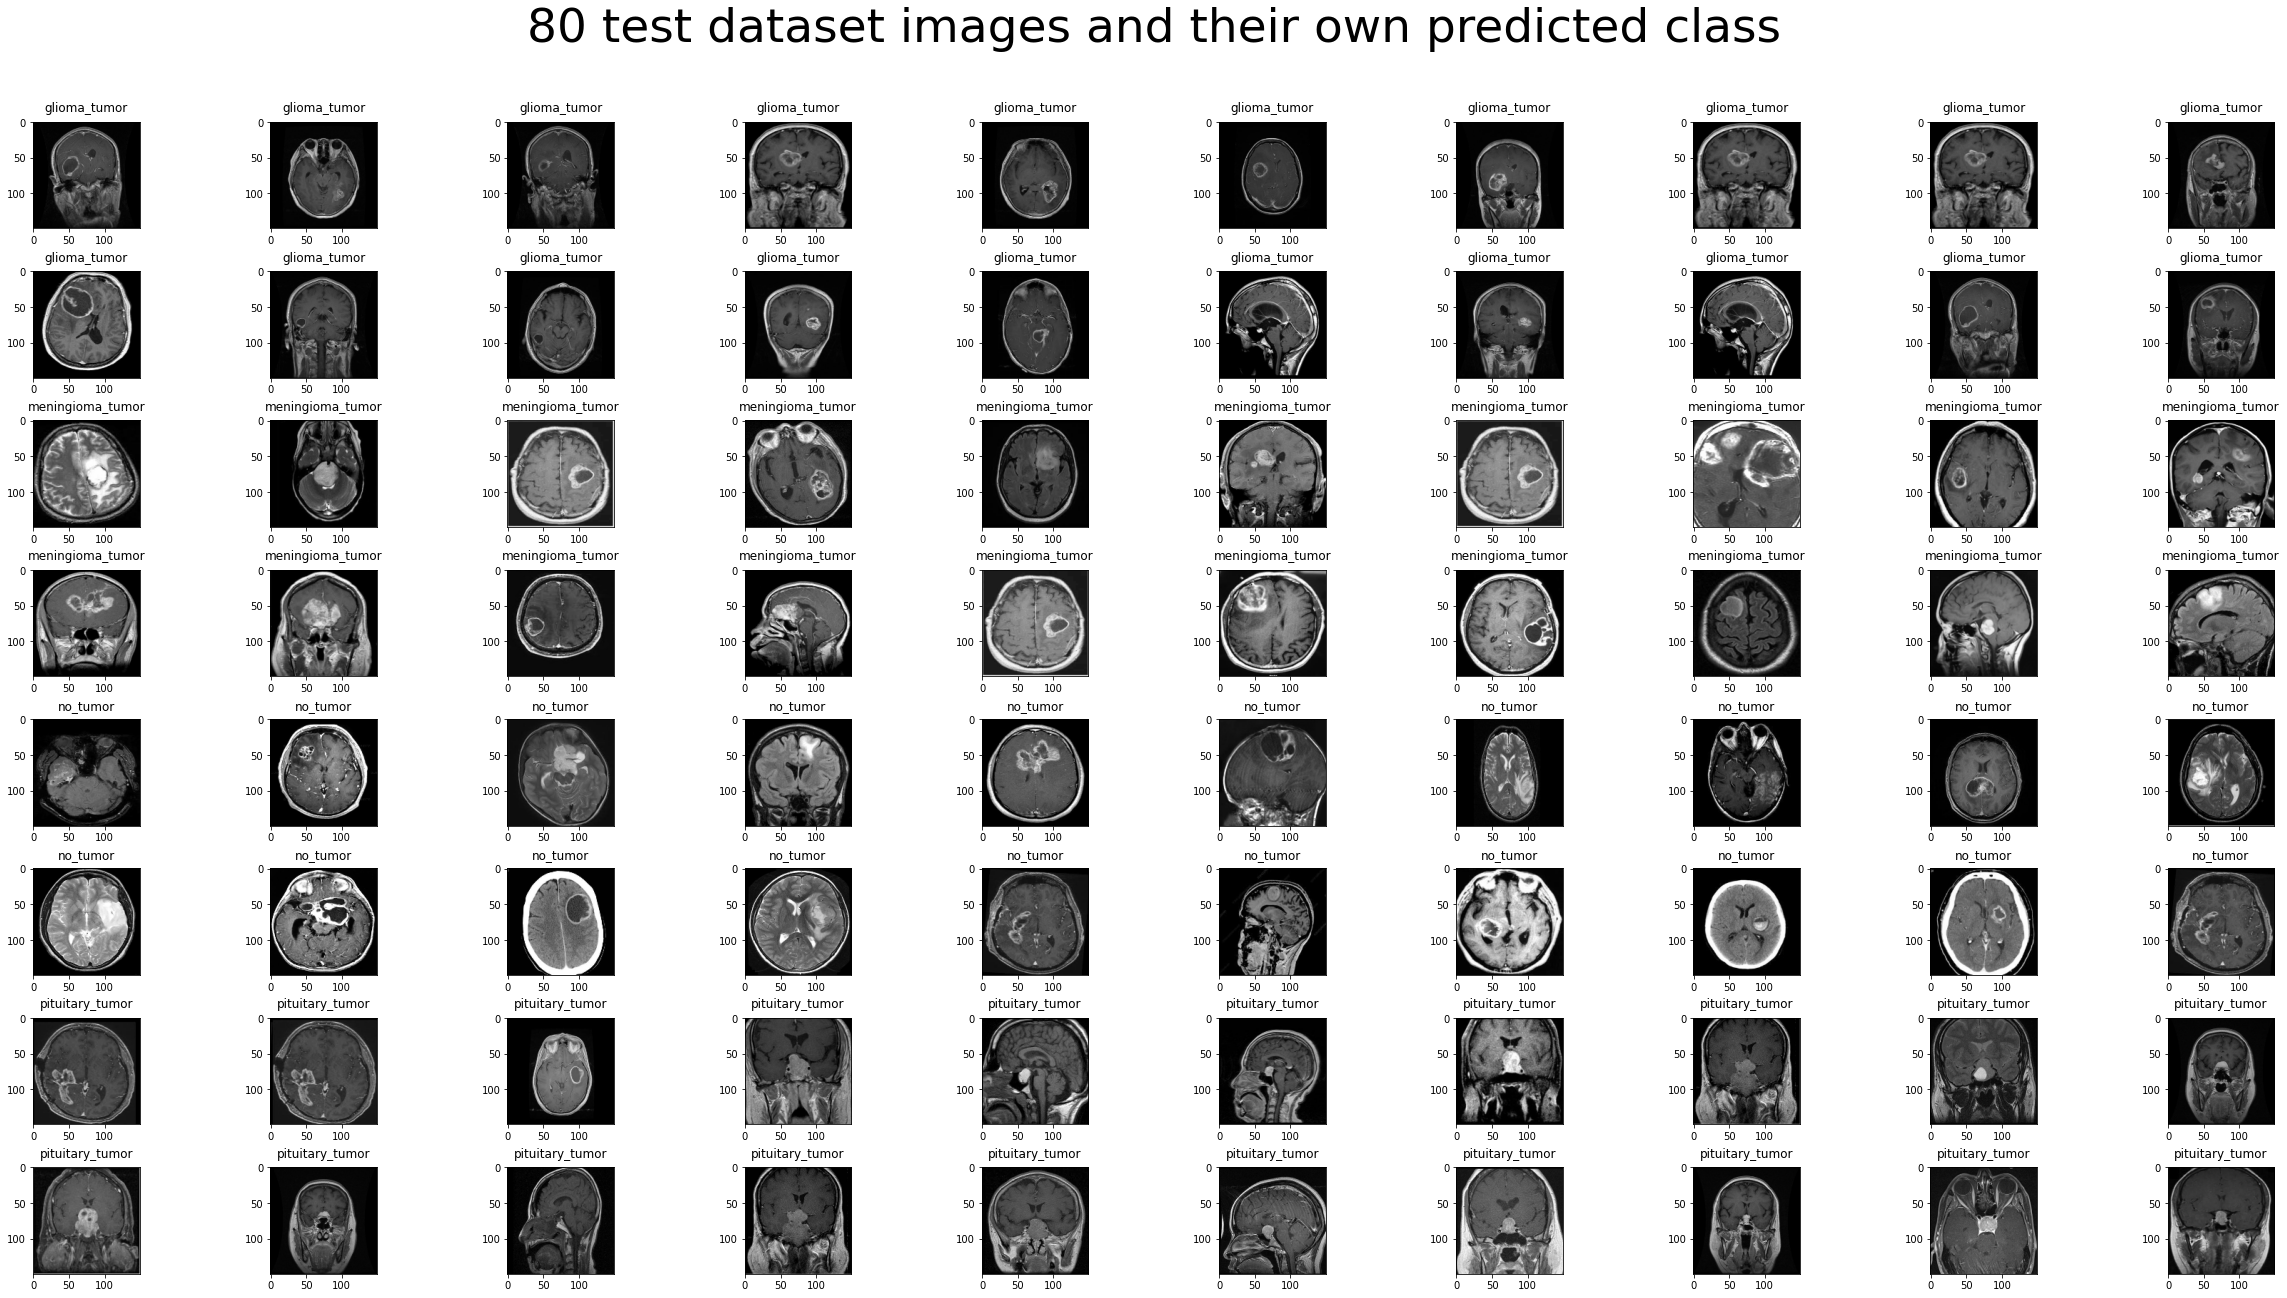

In [27]:
columns = 10
fig,axes=plt.subplots(int(len(X_test_images)*len(X_test_images[0])/columns),columns,figsize=(40,20))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i,ind in enumerate(X_test_images):
    #print(images_class)
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        p='Meningioma Tumor'
    elif p==2:
        print('The model predicts that there is no tumor')
    else:
        p='Pituitary Tumor'

    if p!=2:
        print(f'The Model predicts that it is a {p}')
        
    fig.suptitle('80 test dataset images and their own predicted class',fontsize=47)
    
    for j, image in enumerate(ind):
        #print(j,image)
        if int((i)*(len(ind)/columns)+(int(j/columns)))<n_classes*(z_max/columns):
            axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].imshow(image)
            axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].set_title(f'{labels[i]}',pad=10)

In [28]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        p='Meningioma Tumor'
    elif p==2:
        print('The model predicts that there is no tumor')
    else:
        p='Pituitary Tumor'

    if p!=2:
        print(f'The Model predicts that it is a {p}')

In [29]:
uploader = widgets.FileUpload()
display(uploader)
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

FileUpload(value={}, description='Upload')

In [30]:
from keras.models import load_model
import tensorflow as tf

model = load_model('brain_tumor_classification.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tf_lite_model = converter.convert() 

with open('model.tflite', 'wb') as f:
      f.write(tf_lite_model)

2022-07-11 16:03:06.181486: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-07-11 16:03:35.779543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 16:03:35.779950: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-07-11 16:03:35.780118: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-07-11 16:03:35.780643: I tensorflow/stream_executor/cuda/cuda_gpu_executor.